### **Predicting Heart Disease Risk Using Logistic Regression**

- This analysis explores the use of logistic regression and related linear models to predict the risk of heart disease based on CDC survey data.
- The workflow includes data preprocessing, feature engineering, model fitting, regularization, calibration, and interpretation of results, with a focus on model discrimination, calibration, linearity, multicollinearity, and overfitting control.

In [17]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score,average_precision_score

import warnings
warnings.filterwarnings("ignore")

#### **Load data and preprocess**
- The dataset is a subset and cleaned version of 2022 annual CDC survey data of 400k+ adults related to their health status
- Kaggle link: [CDC Heart Disease Dataset on Kaggle](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease)

In [ ]:
# load the dataset
heart_disease_df = pd.read_csv('heart_2020_cleaned.csv')
heart_disease_df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [27]:
heart_disease_df.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [28]:
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [ ]:
# target variable distribution
heart_disease_df['HeartDisease'].value_counts()

HeartDisease
No     292422
Yes     27373
Name: count, dtype: int64

In [30]:
# convert target variable to binary
heart_disease_df['HeartDisease'] = heart_disease_df['HeartDisease'].map({'Yes': 1, 'No': 0})

In [31]:
# separate features and target variable
X = heart_disease_df.drop('HeartDisease', axis=1)
y = heart_disease_df['HeartDisease']

In [32]:
# one-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

In [35]:
# standardize numerical features
scaler = StandardScaler()
num_cols = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
X[num_cols] = scaler.fit_transform(X[num_cols])

In [ ]:
# values after standardization
X.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
0,-1.844750,-0.046751,3.281069,-1.460354,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,False,False,True,True,False,True
1,-1.256338,-0.424070,-0.490039,-0.067601,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False
2,-0.274603,2.091388,3.281069,0.628776,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,True,True,False,False,False,True,False,False
3,-0.647473,-0.424070,-0.490039,-0.763977,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
4,-0.726138,3.097572,-0.490039,0.628776,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False


In [37]:
# split the data into training and testing sets
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
# helper function to compute VIF
def vif(df: pd.DataFrame):
    Z = (df - df.mean())/(df.std(ddof=0) + 1e-12)
    out = []
    for c in Z.columns:
        y_ = Z[c].values
        X_ = Z.drop(columns=[c]).values
        r2 = LinearRegression().fit(X_, y_).score(X_, y_)
        out.append((c, 1.0/(1.0 - r2 + 1e-12)))
    return pd.DataFrame(out, columns=["feature","VIF"]).sort_values("VIF", ascending=False)

In [40]:
# baseline L2 Logistic Regression
base = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=5000))
]).fit(Xtr, ytr)

proba = base.predict_proba(Xte)[:,1]
print("\n=== Metrics (Discrimination & Calibration) ===")
print(f"ROC AUC: {roc_auc_score(yte, proba):.3f}")
print(f"PR  AUC: {average_precision_score(yte, proba):.3f}")
print(f"Brier :  {brier_score_loss(yte, proba):.4f} (lower is better)")


=== Metrics (Discrimination & Calibration) ===
ROC AUC: 0.838
PR  AUC: 0.346
Brier :  0.0658 (lower is better)


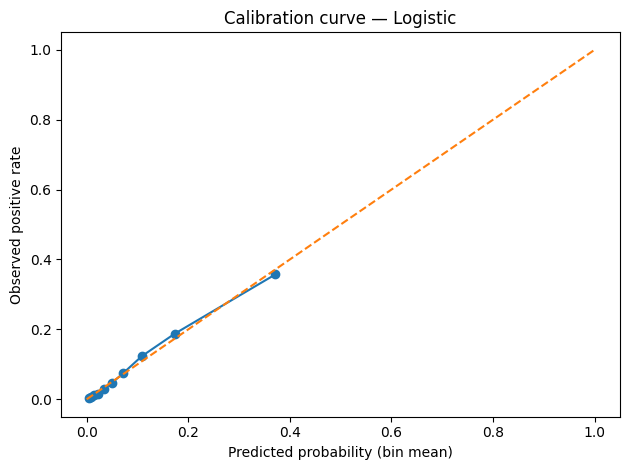

In [41]:
# calibration curve
pt, pp = calibration_curve(yte, proba, n_bins=10, strategy="quantile")
plt.figure(); plt.plot(pp, pt, marker="o"); plt.plot([0,1],[0,1],"--")
plt.xlabel("Predicted probability (bin mean)"); plt.ylabel("Observed positive rate")
plt.title("Calibration curve — Logistic"); plt.tight_layout(); plt.show()

In [42]:
# linearity-in-the-logit check via splines
spline = Pipeline([
    ("spline", SplineTransformer(degree=3, n_knots=5)),
    ("scaler", StandardScaler(with_mean=False)),
    ("logit", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=5000))
])
neg_ll_base = cross_val_score(base, Xtr, ytr, cv=5, scoring="neg_log_loss").mean()
neg_ll_spl  = cross_val_score(spline, Xtr, ytr, cv=5, scoring="neg_log_loss").mean()
print("\n=== Linearity-in-the-logit (CV log-loss; lower is better) ===")
print(f"Base logistic: {-neg_ll_base:.4f}   Spline logistic: {-neg_ll_spl:.4f}")


=== Linearity-in-the-logit (CV log-loss; lower is better) ===
Base logistic: 0.2269   Spline logistic: 0.2266


In [43]:
# multicollinearity via VIF
print("\n=== Top VIFs (collinearity) ===")
v = vif(Xtr)
print(v.head(10).to_string(index=False))
print("Rule of thumb: VIF > ~10 ⇒ severe collinearity; prefer L2/Elastic Net or reduce redundant features.")


=== Top VIFs (collinearity) ===
                feature       VIF
             Race_White 11.337191
          Race_Hispanic  5.788442
             Race_Black  5.054995
             Race_Other  2.989355
      AgeCategory_65-69  2.547274
             Race_Asian  2.520286
      AgeCategory_60-64  2.501748
      AgeCategory_70-74  2.475185
      AgeCategory_55-59  2.313075
AgeCategory_80 or older  2.281330
Rule of thumb: VIF > ~10 ⇒ severe collinearity; prefer L2/Elastic Net or reduce redundant features.



=== Regularization sweep (C) — CV log-loss ===
C=  0.01: CV log-loss=0.2270
C=   0.1: CV log-loss=0.2269
C=   1.0: CV log-loss=0.2269
C=  10.0: CV log-loss=0.2269
C= 100.0: CV log-loss=0.2269


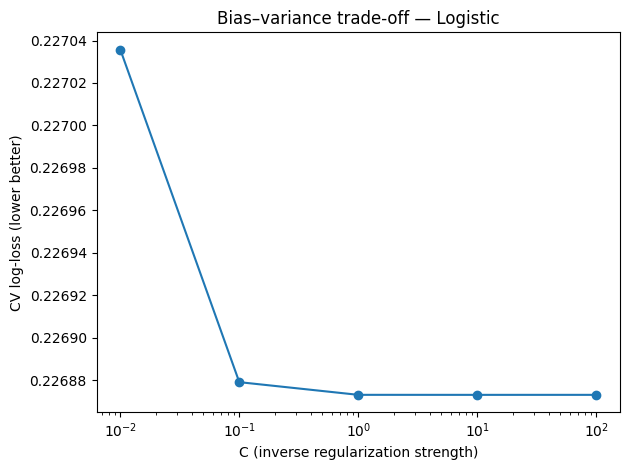

In [44]:
# ---------- Regularization sweep (overfitting control) ----------
print("\n=== Regularization sweep (C) — CV log-loss ===")
Cs = [0.01, 0.1, 1.0, 10.0, 100.0]; cv_ll = []
for C in Cs:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("logit", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=5000, C=C))
    ])
    ll = -cross_val_score(model, Xtr, ytr, cv=5, scoring="neg_log_loss").mean()
    cv_ll.append(ll)
    print(f"C={C:>6}: CV log-loss={ll:.4f}")

plt.figure(); plt.plot(Cs, cv_ll, marker="o"); plt.xscale("log")
plt.xlabel("C (inverse regularization strength)"); plt.ylabel("CV log-loss (lower better)")
plt.title("Bias–variance trade-off — Logistic"); plt.tight_layout(); plt.show()

In [45]:
# separation / overconfidence probabilities
coef = base.named_steps["logit"].coef_.ravel()
extreme = np.mean((proba <= 1e-6) | (proba >= 1-1e-6))
print("\n=== Separation / Overconfidence checks ===")
print(f"Max |coef| (standardized): {np.abs(coef).max():.3f}")
print(f"Fraction of extreme probs on test (≈0 or ≈1): {extreme:.4f}")
print("Large |coef| or many extreme probs can signal (quasi-)separation; increase regularization or review features.")


=== Separation / Overconfidence checks ===
Max |coef| (standardized): 0.824
Fraction of extreme probs on test (≈0 or ≈1): 0.0000
Large |coef| or many extreme probs can signal (quasi-)separation; increase regularization or review features.


### **Results/Interpretations:**

**1. Discrimination & Calibration: ROC/PR AUC, Brier, and the calibration curve.**

- The ROC AUC curve of 0.838 shows that the model discriminates well between the patients with and without heart disease, there is an 83.8% chance that the model will predict a higher risk to a positive case. The PR AUC value of 0.346 is decent and it means the model find many positives but at the cost of some false positives
- Brier score of approximately 0.066 tells that the predicted probabilities are close to true outcomes, indicating strong calibration. 
- The blue line in the calibration curve is aligned closely with the diagonal very closely, which means predicted risks match observed frequencies. One thing to note is that the model rarely predicts probabilities > 0.5, suggesting that it assigns most patients to low and moderate risk bins. 

**2. Linearity-in-the-logit**

- Based on the results, the log-loss barely changes (from 0.2269 to 0.2266) - which explains that linearity assumptions hold well and there is no big gains from the introduction of splines.
- This illustrates that the logistic regression is already good enough and there is no need to perform nonlinear feature transformations like splines.

**3. Multicollinearity: significance of top VIFs**

- From results, the top VIFs are Race_White = 11.3 and other race and age categories (with scores between 2 and 6)
- Race_White is considered highly collinear and it is expected as race categories are dummy-coded and inherently collinear.
- This value doesn't impact the predictive performance as L2 regularization is introduced which shrinks coefficients and stabilizes the estimations.
- On the other side, there is a need to interpret the coefficients on race dummies cautiously as they depend heavily on how the categories are encoded. 

**4. Overfitting control**

- Based on the results from bias-variance trade-off curve, the CV log-loss is flat across C values (from 0.2270 to 0.2269).
- As the performance doesn't change much with regularization strength, the model is not overfitting. 
- The safest choice is C = 1.0 which is the default value as it balances both stability and flexibility without underfitting. In this scenario, choosing C = 0.1 or 10 also gives the same result.

**5. Separation risk:**

- Max |coef| value is 0.824 which is the largest absolute coefficient value after standardizing the predictors. Value below 1 shows that no single predictor has an outsized effect on the log-odds of heart disease. 
- The fraction of extreme possibilities shows how often the model predicts probabilities extremely close to 0 or 1 and the fraction of 0 shows that the model never outputs such overconfident predictions. 
- Based on these metrics, logistic regression model shows no evidence of separation or overconfidence. This demonstrates that model is well calibrated, stable model that generalizes well and doesn't "overfit" to a few extreme patterns in the data.